##Using Convolutions with Complex Images

En los laboratorios anteriores, utilizó el conjunto de datos Fashion MNIST para entrenar un clasificador de imágenes. En este caso, tenía imágenes de 28x28 donde estaba centrado el sujeto. ¡En este laboratorio llevarás esto al siguiente nivel, entrenando para reconocer características en una imagen donde el sujeto puede estar *en cualquier lugar* de la imagen! Lo harás construyendo un clasificador de caballos o humanos que te dirá si una imagen dada contiene un caballo o un humano, donde la red está entrenada para reconocer características que determinan cuál es cuál.


En el caso de Fashion MNIST, los datos se integraron en TensorFlow a través de Keras. En este caso, los datos no son así que tendrá que procesarlos antes de poder entrenar. 

Primero, descarguemos los datos:



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2020-05-09 21:34:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   118MB/s    in 1.2s    

2020-05-09 21:34:51 (118 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-05-09 21:34:52--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/z

El siguiente código de Python utilizará la biblioteca del sistema operativo *os* para acceder al sistema de archivos y a la biblioteca de archivos zip que le permitirá descomprimir los datos.

In [0]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

El contenido del archivo .zip se extrae al directorio `/tmp/horse-or-human`, que a su vez contiene subdirectorios `horses` y `human`. 

En resumen: el conjunto de entrenamiento son los datos que se utilizan para decirle al modelo de red neuronal que "así es como se ve un caballo", "así es como se ve un humano", etc.

Una cosa a la que debe prestar atención en esta muestra: no etiquetamos explícitamente las imágenes como caballos o humanos. Si recuerdas con el ejemplo de moda anterior, habíamos etiquetado 'este es un 1', 'este es un 7', etc. 

Más adelante verá que se usa algo llamado *ImageGenerator*, y está codificado para leer imágenes de subdirectorios y etiquetarlas automáticamente con el nombre de ese subdirectorio. Entonces, por ejemplo, tendrá un directorio de 'entrenamiento' que contiene un directorio de 'caballos' y uno de 'humanos'. ImageGenerator etiquetará las imágenes apropiadamente para usted, reduciendo un paso de codificación.

Definamos cada uno de estos directorios: 

In [0]:
# Directorio con nuestras fotos de caballos de entrenamiento
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directorio con nuestras fotos de caballos de personas
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directorio con nuestras fotos de caballos de validación
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directorio con nuestras fotos de personas de validación
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

Ahora, veamos cómo se ven los nombres de archivo en los directorios de entrenamiento de `caballos` y` personas`:

In [7]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse43-0.png', 'horse27-2.png', 'horse21-4.png', 'horse11-7.png', 'horse34-5.png', 'horse03-6.png', 'horse33-7.png', 'horse01-5.png', 'horse46-0.png', 'horse34-7.png']
['human10-08.png', 'human11-06.png', 'human07-01.png', 'human09-21.png', 'human17-30.png', 'human03-11.png', 'human08-19.png', 'human01-16.png', 'human07-07.png', 'human11-16.png']


Veamos el número total de imágenes de caballos y humanos en los directorios:


In [8]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Ahora echemos un vistazo a algunas imágenes para tener una mejor idea de cómo se ven. Primero, configure los parámetros de matplot:

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parámetros para nuestro gráfico; mostraremos imágenes en una configuración 4x4
nrows = 4
ncols = 4

# Índice para iterar sobre imágenes
pic_index = 0

Ahora, muestre un lote de 8 caballos y 8 imágenes humanas. Puede volver a ejecutar la celda para ver un lote nuevo cada vez:

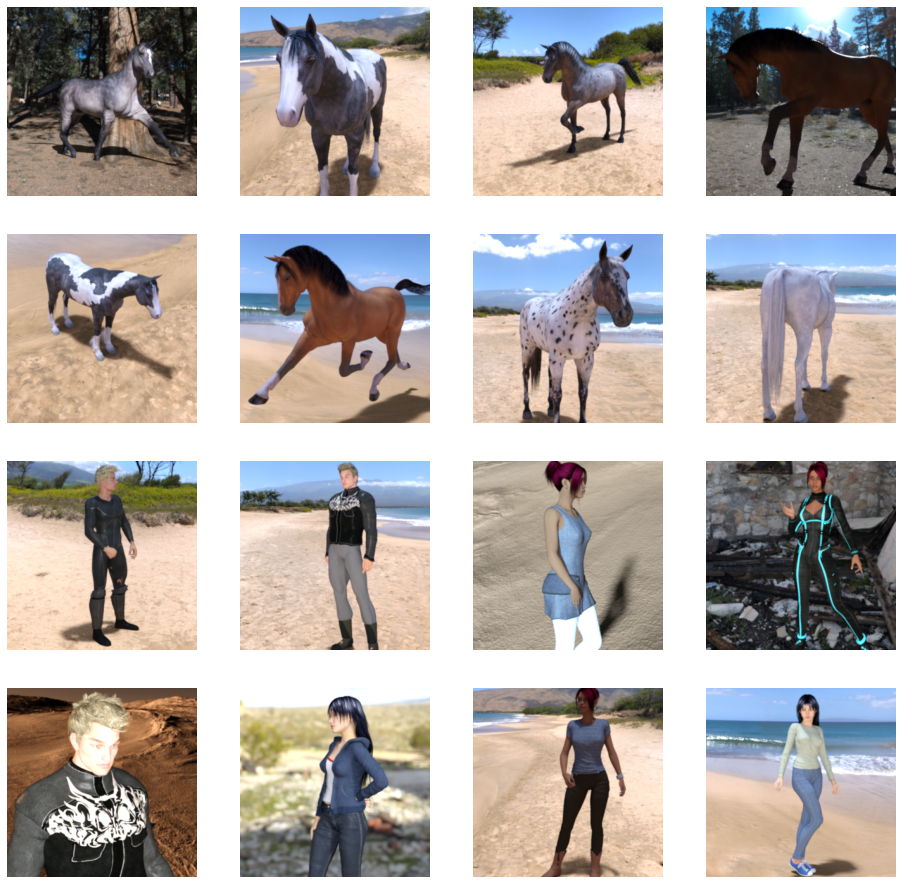

In [13]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a Small Model from Scratch

Pero antes de continuar, comencemos a definir el modelo: 

El primer paso será importar tensorflow.

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
  import tensorflow as tf
except Exception:
  pass

In [15]:
print(tf.__version__)

2.2.0-rc4


Empezamos con agregando capas convolucionales como en el ejemplo anterior, y aplanamos el resultado final para alimentar las capas densamente conectadas.Despues, agregamos las capas densamente conectadas.

Tenga en cuenta que debido a que enfrentamos un problema de clasificación de dos clases, es decir, un *problema de clasificación binario*, finalizaremos nuestra red con una activación [*sigmoide*] (https://wikipedia.org/wiki/Sigmoid_function), de modo que La salida de nuestra red será un solo escalar entre 0 y 1, codificando la probabilidad de que la imagen actual sea de clase 1 (en oposición a la clase 0).

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

La llamada al método model.summary () imprime un resumen de NN

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

La columna "Output Shape" muestra cómo evoluciona el tamaño de su mapa de características en cada capa sucesiva. Las capas de convolución reducen un poco el tamaño de los mapas de entidades debido a los filtros, y cada capa de pooling reduce a la mitad las dimensiones.

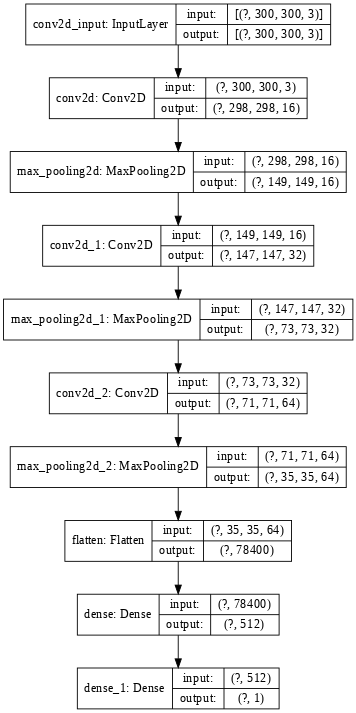

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

A continuación, configuraremos las especificaciones para el entrenamiento del modelo. Entrenaremos nuestro modelo con la pérdida `binary_crossentropy`, porque es un problema de clasificación binaria y nuestra activación final es sigmoidea. Usaremos El optimizador `rmsprop` con una tasa de aprendizaje de` 0.001`. Durante el entrenamiento, querremos monitorear la precisión de la clasificación.

En este caso, usar el [algoritmo de optimización RMSprop](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) es preferible a [descenso de gradiente estocástico](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), porque RMSprop automatiza el ajuste de la tasa de aprendizaje para nosotros. (Otros optimizadores, como [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) y [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), también adapta automáticamente la tasa de aprendizaje durante el entrenamiento, y funcionaría igualmente bien aquí).

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Configuremos generadores de datos que lean imágenes en nuestras carpetas de origen, las conviertan en tensores `float32` y las alimenten (con sus etiquetas) a nuestra red. Tendremos un generador para las imágenes de entrenamiento y otro para las imágenes de validación. Nuestros generadores producirán lotes de imágenes de tamaño 300x300 y sus etiquetas (binarias). 

Como ya sabrá, los datos que ingresan a las redes neuronales generalmente deben normalizarse de alguna manera para que sean más susceptibles de ser procesados ​​por la red. (Es poco común alimentar píxeles sin formato en una red de conexión.) En nuestro caso, procesaremos previamente nuestras imágenes normalizando los valores de píxeles para que estén en el rango `[0, 1]` (originalmente todos los valores están en el `[0, 255] `rango).

En Keras, esto se puede hacer a través de la clase `keras.preprocessing.image.ImageDataGenerator` utilizando el parámetro `rescale`. Esta clase `ImageDataGenerator` le permite instanciar generadores de lotes de imágenes aumentadas (y sus etiquetas) a través de `.flow (datos, etiquetas)` o `.flow_from_directory(directorio)`. Estos generadores se pueden usar con los métodos del modelo Keras que aceptan generadores de datos como entradas: `fit_generator`, `Evaluation_generator` y `predict_generator`.

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',                                                 # This is the source directory for training images
        target_size=(300, 300),                                                 # All images will be resized to 150x150
        batch_size=128,
        class_mode='binary')                                                    # Since we use binary_crossentropy loss, we need binary labels


validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',                                      # This is the source directory for training images
        target_size=(300, 300),                                                 # All images will be resized to 150x150
        batch_size=32,
        class_mode='binary')                                                    # Since we use binary_crossentropy loss, we need binary labels

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Training
Vamos a entrenar durante 15 épocas; esto puede tardar unos minutos en ejecutarse. 

Tenga en cuenta los valores por época. La pérdida y la exactitud son una gran indicación del progreso del entrenamiento. Se trata de adivinar la clasificación de los datos de entrenamiento y luego medirlos con la etiqueta conocida y calcular el resultado. La exactitud el ratio de conjeturas correctas.

In [21]:
history = model.fit(
      train_generator,
      validation_data = validation_generator,  
      epochs=15,
      steps_per_epoch=8,
      validation_steps=8,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 7s 874ms/step - loss: 5.5677 - accuracy: 0.5098 - val_loss: 0.7027 - val_accuracy: 0.5078
Epoch 2/15
8/8 [==============================] - 8s 991ms/step - loss: 0.4456 - accuracy: 0.7864 - val_loss: 0.5523 - val_accuracy: 0.6953
Epoch 3/15
8/8 [==============================] - 7s 874ms/step - loss: 0.3870 - accuracy: 0.8509 - val_loss: 1.9086 - val_accuracy: 0.6875
Epoch 4/15
8/8 [==============================] - 7s 868ms/step - loss: 0.2072 - accuracy: 0.9221 - val_loss: 0.9932 - val_accuracy: 0.7773
Epoch 5/15
8/8 [==============================] - 7s 875ms/step - loss: 0.6423 - accuracy: 0.8888 - val_loss: 1.2628 - val_accuracy: 0.7812
Epoch 6/15
8/8 [==============================] - 7s 882ms/step - loss: 0.0559 - accuracy: 0.9833 - val_loss: 1.0158 - val_accuracy: 0.8164
Epoch 7/15
8/8 [==============================] - 7s 870ms/step - loss: 0.0227 - accuracy: 0.9956 - val_loss: 1.7719 - val_accuracy: 0.7812
Epoch 8/15
8/8 [====

###Running the Model


Veamos ahora cómo ejecutar una predicción usando el modelo. Este código le permitirá elegir 1 o más archivos de su sistema de archivos, luego los cargará y los ejecutará a través del modelo, dando una indicación de si el objeto es un caballo o un humano.

¡Puede descargar imágenes de Internet a su sistema de archivos para probarlas! Tenga en cuenta que es posible que vea que la red comete MUCHOS errores, a pesar de que la precisión del entrenamiento es superior al 99%.

Esto se debe a algo llamado **overfitting**, lo que significa que la red neuronal está entrenada con datos muy limitados: solo hay 500 imágenes de cada clase. Por lo tanto, es muy bueno para reconocer imágenes que se parecen a las del conjunto de entrenamiento, pero puede fallar mucho en las imágenes que no están en el conjunto de entrenamiento.

¡Este es un punto de datos que demuestra que cuantos más datos entrenes, mejor será tu red final! 

Existen muchas técnicas que pueden utilizarse para mejorar su entrenamiento, a pesar de los datos limitados, incluido algo llamado Aumento de imagen. ¡Eso está más allá del alcance de este laboratorio!

In [29]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " es humano")
  else:
    print(fn + " es caballo")
 

Saving descarga.jpg to descarga (1).jpg
[0.]
descarga.jpg es caballo


### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


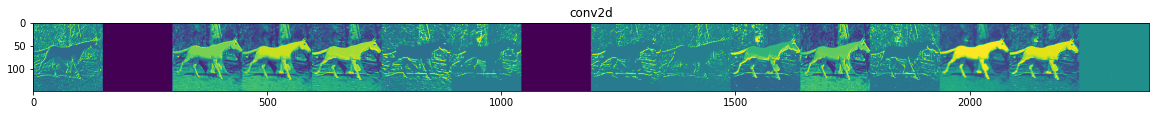

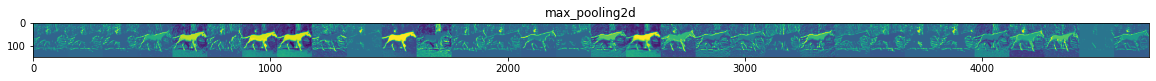

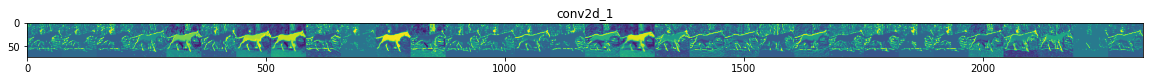

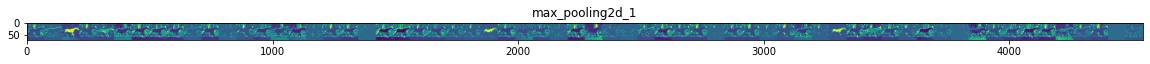

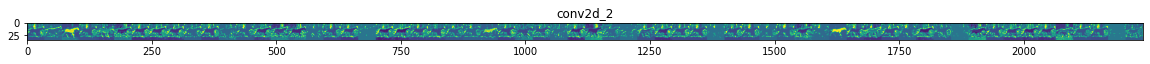

In [27]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.


These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.